## Import required packages

In [440]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
import torch

import eli5
from eli5.sklearn import PermutationImportance
from mlxtend.classifier import StackingClassifier, StackingCVClassifier
from mlxtend.plotting import plot_learning_curves

from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from IPython.display import display

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

RANDOM_SEED = 33

## Context
This dataset is collected from UCI Machine Learning Repository through the following link: https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification#

Data Set Information:

The data used in this study were gathered from 188 patients with PD (107 men and 81 women) with ages ranging from 33 to 87 (65.1Â±10.9) at the Department of Neurology in CerrahpaÅŸa Faculty of Medicine, Istanbul University. The control group consists of 64 healthy individuals (23 men and 41 women) with ages varying between 41 and 82 (61.1Â±8.9). During the data collection process, the microphone is set to 44.1 KHz and following the physicianâ€™s examination, the sustained phonation of the vowel /a/ was collected from each subject with three repetitions.

Attribute Information:

Various speech signal processing algorithms including Time Frequency Features, Mel Frequency Cepstral Coefficients (MFCCs), Wavelet Transform based Features, Vocal Fold Features and TWQT features have been applied to the speech recordings of Parkinson's Disease (PD) patients to extract clinically useful information for PD assessment.

## 1. Data loading
### 1.1 Extract featurs (X) and labels (y) from data file

In [441]:
# Load data and convert to DataFrame object
data = pd.read_csv('dataset/parkinsons.csv')

# extracts feature data from the data
X = data.drop(['id', 'class'], axis=1)
# extracts labels for each samples and covert to an array
y = data['class'].to_numpy(np.int32)

# extracts feature names and convert to a numpy array
FEATURES = X.columns.to_numpy()

In [442]:
# counts the number of each label
labels, label_counts = np.unique(y, return_counts=True)

for i in range(len(labels)):
    print('Number of samples labelled to {}: {}'.format(
        labels[i], label_counts[i]))

print('Number of total samples: {}'.format(sum(label_counts)))
print('Number of total features: {}'.format(len(FEATURES)))

Number of samples labelled to 0: 192
Number of samples labelled to 1: 564
Number of total samples: 756
Number of total features: 753


### 1.2 Show the summary statistics

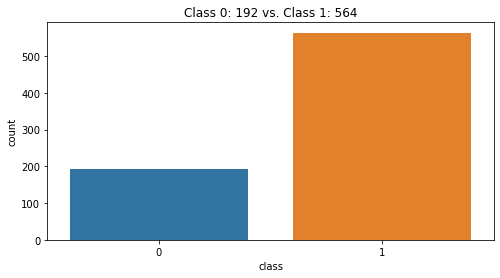

In [443]:
plt.figure(figsize=(8, 4))
sns.countplot(x='class', data=data)
plt.title('Class 0: {} vs. Class 1: {}'.format(label_counts[0],
                                               label_counts[1]))
plt.show()

In [444]:
# display the summary stacts of the dataset
X.describe()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,...,21.026054,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110
std,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,...,43.716898,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991
min,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,6.860000e-07,...,1.342700,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000
25%,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,5.260000e-06,...,1.814850,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750
50%,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,9.530000e-06,...,3.075050,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250
75%,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,1.832500e-05,...,12.129975,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325
max,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,2.564800e-04,...,355.516100,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700


In [445]:
# Show the details of first 5 samples
data.drop(['id'], axis=1).head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


### 1.3 Split samples to training dataset and test dataset
Split data into training dataset (80%) and test dataset(20%) by [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [446]:
# Split samples to training data (80%) and test data(20%)
X_trn, X_tst, y_train, y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2,
                                                 random_state=RANDOM_SEED)

## 2. Data Processing
### 2.1 Data preprocessing
Transform data to usable and meaningful information using [sklearn.preprocessing.StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)
$$
x' = \frac{x-\bar{X}}{S}
$$

In [447]:
## Standardize features
scaler = StandardScaler().fit(X_trn)
X_train = scaler.transform(X_trn)
X_test = scaler.transform(X_tst)

### 2.2. Feature Selection
Feature selection methods can be used to identify and remove unneeded, irrelevant and redundant attributes from data that do not contribute to the accuracy of a predictive model or may in fact decrease the accuracy of the model.

Fewer attributes is desirable because it reduces the complexity of the model, and a simpler model is simpler to understand and explain.
#### 2.2.1 Evaluate feature importance
1. Compute the permutation feature weights with [eli5.sklearn.PermutationImportance](https://eli5.readthedocs.io/en/latest/autodocs/sklearn.html#eli5.sklearn.permutation_importance.PermutationImportance) based on [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)
2. Identify and select most important features [sklearn.feature_selection.SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel)

In [448]:
perm = PermutationImportance(estimator=RandomForestClassifier(
    n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1),
                             cv=5,
                             random_state=RANDOM_SEED).fit(X_train, y_train)

In [449]:
# Display the explanation of permuation importance
eli5.show_weights(perm, feature_names=FEATURES)

Weight,Feature
0.0046 ± 0.0115,std_9th_delta
0.0030 ± 0.0092,tqwt_TKEO_mean_dec_35
0.0027 ± 0.0102,std_delta_log_energy
0.0026 ± 0.0077,tqwt_entropy_log_dec_13
0.0026 ± 0.0146,tqwt_TKEO_std_dec_7
0.0023 ± 0.0074,tqwt_skewnessValue_dec_25
0.0023 ± 0.0074,tqwt_entropy_log_dec_33
0.0023 ± 0.0088,tqwt_stdValue_dec_15
0.0023 ± 0.0074,tqwt_TKEO_mean_dec_14
0.0023 ± 0.0128,tqwt_entropy_log_dec_35


In [450]:
# Remain the featuers with importance greater than the mean value
sfm = SelectFromModel(perm).fit(X_train, y_train)

print('retain features with importance greater or eaqual to {}'.format(
    sfm.threshold_))

retain features with importance greater or eaqual to 2.6527498820143803e-05


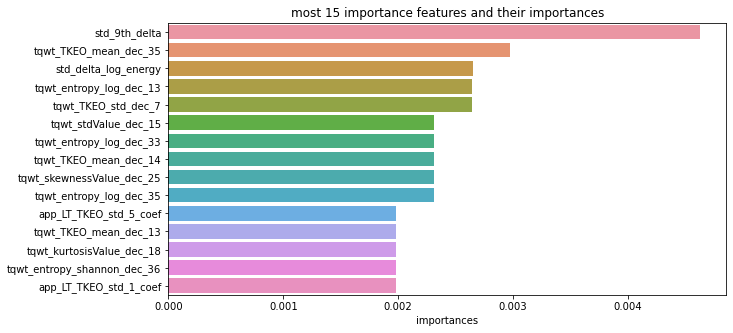

In [451]:
# Get the indices of the most 15 important features
sort_i = np.argsort(perm.feature_importances_ * -1)[:15]

# Plot the most 15 important features and importances
plt.figure(figsize=(10, 5))
sns.barplot(y=FEATURES[sort_i],
            x=perm.feature_importances_[sort_i],
            orient='h')
plt.xlabel('importances')
plt.title('most 15 importance features and their importances')
plt.show()

In [452]:
# Get the index list of the selected features
selected_i = sfm.get_support(indices=True)

In [453]:
# Print the name of selected features
IMPORTANT_FEATURES = FEATURES[selected_i]
print(IMPORTANT_FEATURES)

['numPeriodsPulses' 'locAbsJitter' 'rapJitter' 'f1' 'f3' 'b3' 'GNE_mean'
 'GNE_SNR_SEO' 'IMF_SNR_SEO' 'mean_MFCC_2nd_coef' 'mean_MFCC_3rd_coef'
 'mean_MFCC_4th_coef' 'mean_MFCC_6th_coef' 'mean_MFCC_11th_coef'
 'mean_3rd_delta' 'mean_8th_delta' 'mean_5th_delta_delta'
 'mean_7th_delta_delta' 'std_MFCC_4th_coef' 'std_MFCC_9th_coef'
 'std_delta_log_energy' 'std_0th_delta' 'std_3rd_delta' 'std_7th_delta'
 'std_9th_delta' 'std_delta_delta_0th' 'std_4th_delta_delta'
 'std_7th_delta_delta' 'std_9th_delta_delta' 'std_10th_delta_delta'
 'std_11th_delta_delta' 'Ed_4_coef' 'Ed_10_coef'
 'det_entropy_shannon_2_coef' 'det_entropy_shannon_9_coef'
 'det_entropy_log_2_coef' 'det_TKEO_mean_5_coef' 'det_TKEO_mean_10_coef'
 'det_TKEO_std_2_coef' 'det_TKEO_std_8_coef' 'app_entropy_shannon_1_coef'
 'app_entropy_shannon_2_coef' 'app_entropy_log_2_coef'
 'app_entropy_log_3_coef' 'app_entropy_log_7_coef'
 'app_entropy_log_8_coef' 'app_det_TKEO_mean_1_coef'
 'app_det_TKEO_mean_2_coef' 'app_det_TKEO_mean_4_coef'

#### 2.2.2 Reduce training data to selected features

In [454]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)
print('The shape of X_train changed from {} to {}'.format(
    X_train.shape, X_important_train.shape))
print('\nThe shape of X_test changed from {} to {}'.format(
    X_test.shape, X_important_test.shape))

The shape of X_train changed from (604, 753) to (604, 221)

The shape of X_test changed from (152, 753) to (152, 221)


In [455]:
# Predefined functions
# Since we will use different parameter tuning algorithms, it reduces the code
def search_best(X, y, search_class, model, param_grids, **kwargs):
    search = search_class(model, param_grids, **kwargs).fit(X, y)
    print('Mean cross-validated score of the best_estimator: {}'.format(
        search.best_score_))
    print('Parameter setting that gave the best results:')
    pprint(search.best_params_)
    return search.best_estimator_, search.best_score_, search.best_params_


def print_acc(estimator):
    print('Training accuracy: {:.2f}%'.format(
        estimator.score(X_important_train, y_train) * 100))
    print('Test accuracy:     {:.2f}%'.format(
        estimator.score(X_important_test, y_test) * 100))
    


def estimator_performance(estimator):
    print('Classification report on training data')
    print(
        classification_report(y_train,
                              estimator.predict(X_important_train),
                              labels=[0, 1],
                              digits=4))
    print('Classification report on test data')
    print(
        classification_report(y_test,
                              estimator.predict(X_important_test),
                              labels=[0, 1],
                              digits=4))
    plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(121)
    plt.title('Confusion matrix for training dataset')
    plot_confusion_matrix(estimator,
                          X_important_train,
                          y_train,
                          labels=[0, 1],
                          ax=ax1)
    ax2 = plt.subplot(122)
    plt.title('Confusion matrix for test dataset')
    plot_confusion_matrix(estimator,
                          X_important_test,
                          y_test,
                          labels=[0, 1],
                          ax=ax2)
    plt.show()
    

def plot_lcurve(model):
    plot_learning_curves(X_important_train, y_train, X_important_test, y_test, model)
    plt.show()
    

## 3. Guassian Naive Bayes
Use [sklearn.naive_bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) to train the data

In [456]:
nb = GaussianNB().fit(X_important_train, y_train)

In [457]:
print_acc(nb)

Training accuracy: 82.62%
Test accuracy:     80.92%


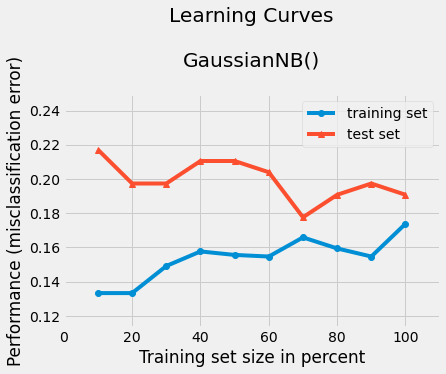

In [458]:
plot_lcurve(nb)

Classification report on training data
              precision    recall  f1-score   support

           0     0.6861    0.6026    0.6416       156
           1     0.8672    0.9040    0.8852       448

    accuracy                         0.8262       604
   macro avg     0.7767    0.7533    0.7634       604
weighted avg     0.8205    0.8262    0.8223       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.5897    0.6389    0.6133        36
           1     0.8850    0.8621    0.8734       116

    accuracy                         0.8092       152
   macro avg     0.7373    0.7505    0.7433       152
weighted avg     0.8150    0.8092    0.8118       152



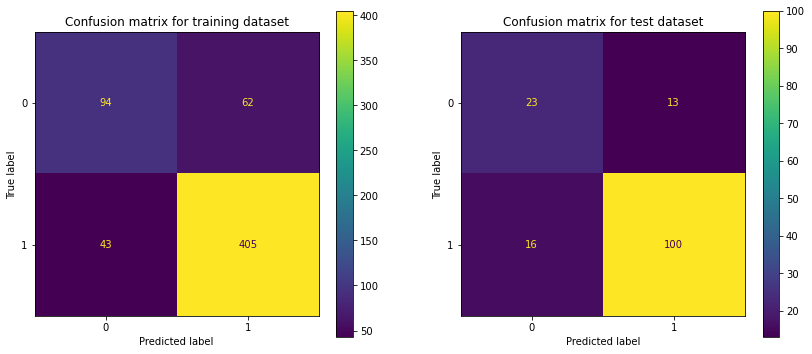

In [459]:
estimator_performance(nb)

## 4 Logistic Regression Training
### 4.1 Find the optimal parameters
Parameter tuning on [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) with [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)

In [460]:
lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'C': np.logspace(-5, 0, num=6)
}

pprint(lr_param_grid)

{'C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


In [461]:
lr_model = LogisticRegression(max_iter=10000, random_state=RANDOM_SEED)

best_lr, lr_cro_val_score, best_lr_params = search_best(X_important_train,
                                                        y_train,
                                                        GridSearchCV,
                                                        lr_model,
                                                        lr_param_grid,
                                                        cv=5,
                                                        scoring='f1',
                                                        n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9101826949883094
Parameter setting that gave the best results:
{'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [462]:
print('Paramater list for the estimator')
pprint(best_lr.get_params())

Paramater list for the estimator
{'C': 0.1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': 33,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### 4.2 Analysis the performance of the best estimator

In [463]:
# Show the prediction on the first sample in test data set
eli5.show_prediction(best_lr, X_important_test[0], show_feature_values=True, feature_names=IMPORTANT_FEATURES)

In [464]:
print_acc(best_lr)

Training accuracy: 88.25%
Test accuracy:     86.18%


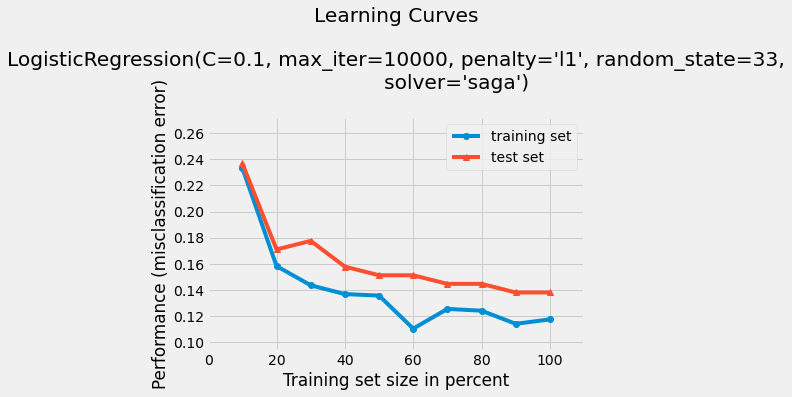

In [465]:
plot_lcurve(best_lr)

Classification report on training data
              precision    recall  f1-score   support

           0     0.8899    0.6218    0.7321       156
           1     0.8808    0.9732    0.9247       448

    accuracy                         0.8825       604
   macro avg     0.8854    0.7975    0.8284       604
weighted avg     0.8832    0.8825    0.8750       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.8261    0.5278    0.6441        36
           1     0.8682    0.9655    0.9143       116

    accuracy                         0.8618       152
   macro avg     0.8472    0.7466    0.7792       152
weighted avg     0.8582    0.8618    0.8503       152



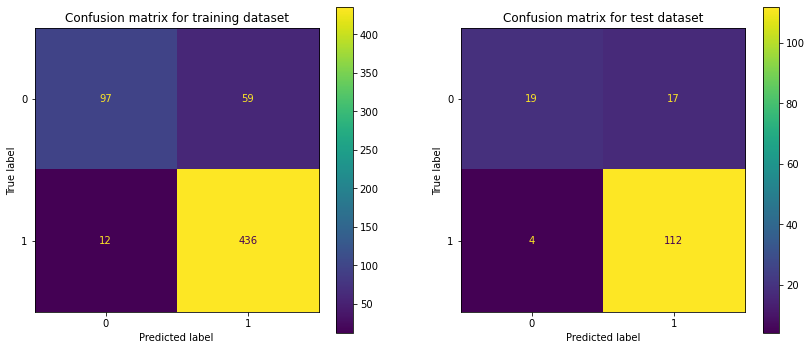

In [466]:
estimator_performance(best_lr)

## 5 Support Vector Machine
### 5.1 Parameter tuning
Find the optimal parameters of [sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) using [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)

In [467]:
svm_param_grid = {
    'C': np.logspace(-4, 3, num=8),
    'gamma': np.logspace(-4, 0, num=5),
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

pprint(svm_param_grid)

{'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}


In [468]:
svm_model = SVC(max_iter=10000, random_state=RANDOM_SEED)

best_svm, svm_cro_val_score, best_svm_params = search_best(X_important_train,
                                                           y_train,
                                                           GridSearchCV,
                                                           svm_model,
                                                           svm_param_grid,
                                                           scoring='f1',
                                                           cv=5,
                                                           n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9232382169595363
Parameter setting that gave the best results:
{'C': 0.0001, 'gamma': 1.0, 'kernel': 'poly'}


In [469]:
print('Paramater list for the estimator')
pprint(best_svm.get_params())

Paramater list for the estimator
{'C': 0.0001,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1.0,
 'kernel': 'poly',
 'max_iter': 10000,
 'probability': False,
 'random_state': 33,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


### 5.2 Analysis the performance of the best estimator

In [470]:
print_acc(best_svm)

Training accuracy: 100.00%
Test accuracy:     90.13%


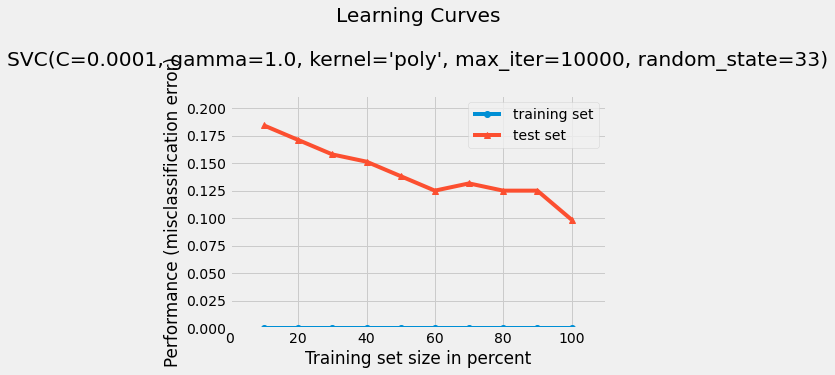

In [471]:
plot_lcurve(best_svm)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.8000    0.7778    0.7887        36
           1     0.9316    0.9397    0.9356       116

    accuracy                         0.9013       152
   macro avg     0.8658    0.8587    0.8622       152
weighted avg     0.9004    0.9013    0.9008       152



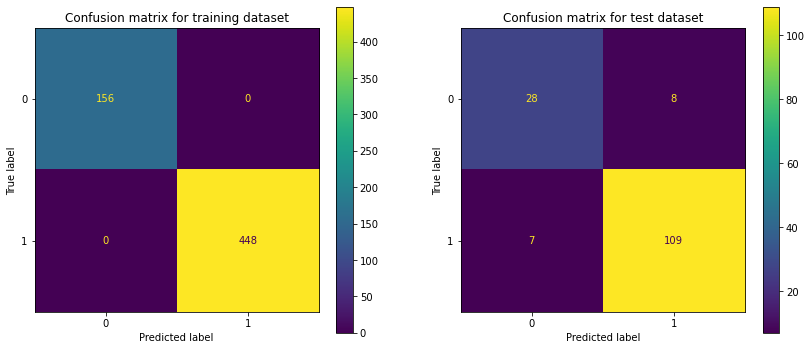

In [472]:
estimator_performance(best_svm)

## 6 K-nearest Neighbor Classifier
### 6.1 Parameter tuning
Use [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV) to optimize the parameters of [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier)

In [473]:
knn_param_grids = {'n_neighbors': np.arange(1, 6), 'p': [1, 2, 3]}

pprint(knn_param_grids)

{'n_neighbors': array([1, 2, 3, 4, 5]), 'p': [1, 2, 3]}


In [474]:
knn_clf = KNeighborsClassifier(algorithm='auto', n_jobs=-1)

best_knn, knn_cro_val_score, best_knn_params = search_best(X_important_train,
                                                           y_train,
                                                           GridSearchCV,
                                                           knn_clf,
                                                           knn_param_grids,
                                                           cv=5,
                                                           n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9320936639118458
Parameter setting that gave the best results:
{'n_neighbors': 1, 'p': 1}


In [475]:
print('Paramater list for the estimator')
pprint(best_knn.get_params())

Paramater list for the estimator
{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 1,
 'p': 1,
 'weights': 'uniform'}


### 6.2 Analyze the performance of the best estimator

In [476]:
print_acc(best_knn)

Training accuracy: 100.00%
Test accuracy:     92.76%


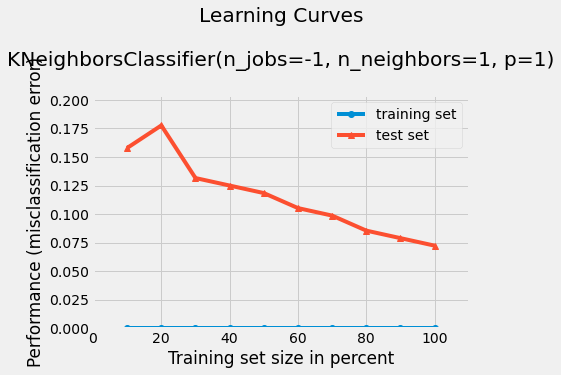

In [477]:
plot_lcurve(best_knn)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.8378    0.8611    0.8493        36
           1     0.9565    0.9483    0.9524       116

    accuracy                         0.9276       152
   macro avg     0.8972    0.9047    0.9008       152
weighted avg     0.9284    0.9276    0.9280       152



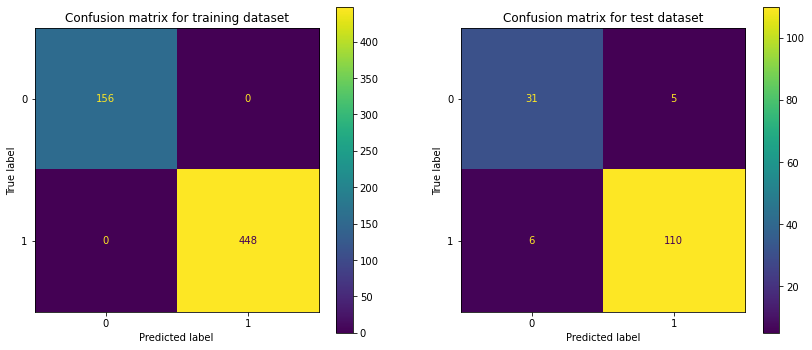

In [478]:
estimator_performance(best_knn)

## 7. Extra Trees Classifier
### 7.1 Parameter tuning by Bayes Search
Use [skopt.BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) to optimize the parameters of [sklearn.ensemble.ExtraTreesClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html) by cross-validated search over parameter settings

In [479]:
xtree_search_spaces = {
    'n_estimators': Categorical([200, 300, 400]),
    'max_features': Real(0.25, 1),
    'max_depth': Categorical([30, 40, 50, 60, None]),
    'min_samples_split': Integer(2, 8),
    'min_samples_leaf': Integer(1, 4),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}
pprint(xtree_search_spaces)

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': Categorical(categories=(30, 40, 50, 60, None), prior=None),
 'max_features': Real(low=0.25, high=1, prior='uniform', transform='identity'),
 'min_samples_leaf': Integer(low=1, high=4, prior='uniform', transform='identity'),
 'min_samples_split': Integer(low=2, high=8, prior='uniform', transform='identity'),
 'n_estimators': Categorical(categories=(200, 300, 400), prior=None)}


In [480]:
xtrees_model = ExtraTreesClassifier(random_state=RANDOM_SEED)

best_xtrees, xtrees_cro_val_score, best_xtrees_params = search_best(
    X_important_train,
    y_train,
    BayesSearchCV,
    xtrees_model,
    xtree_search_spaces,
    random_state=RANDOM_SEED,
    scoring='f1',
    n_iter=100,
    cv=5,
    n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9418235013649163
Parameter setting that gave the best results:
OrderedDict([('bootstrap', False),
             ('criterion', 'entropy'),
             ('max_depth', None),
             ('max_features', 1.0),
             ('min_samples_leaf', 1),
             ('min_samples_split', 4),
             ('n_estimators', 300)])


In [481]:
# Get the best parameter list
print('The parameter list for the best estimator')
pprint(best_xtrees.get_params())

The parameter list for the best estimator
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 33,
 'verbose': 0,
 'warm_start': False}


### 7.2 Analyze the performance of the best estimator

In [482]:
# Show the prediction on the first sample in test data set
eli5.show_prediction(best_xtrees, X_important_test[0], show_feature_values=True, feature_names=IMPORTANT_FEATURES)

In [483]:
print_acc(best_xtrees)

Training accuracy: 100.00%
Test accuracy:     93.42%


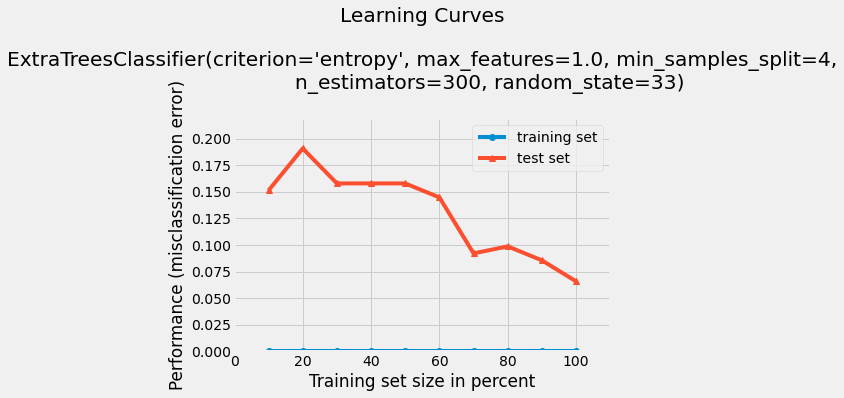

In [484]:
plot_lcurve(best_xtrees)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.9062    0.8056    0.8529        36
           1     0.9417    0.9741    0.9576       116

    accuracy                         0.9342       152
   macro avg     0.9240    0.8898    0.9053       152
weighted avg     0.9333    0.9342    0.9328       152



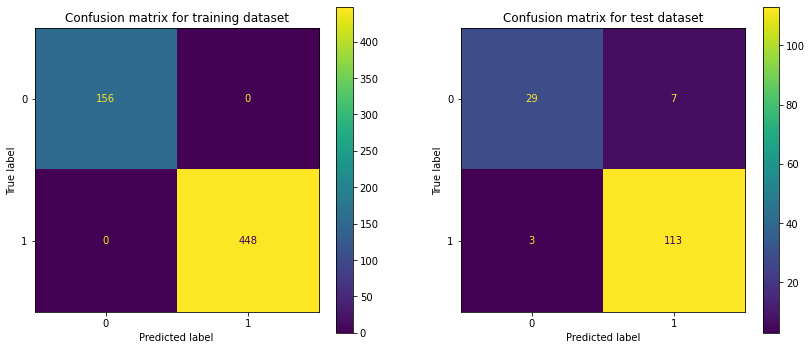

In [485]:
estimator_performance(best_xtrees)

## 8 AdaBoost Classifier
### 8.1 Parameter tuning
Find the optimal parameters of [sklearn.ensemble.AdaBoostClassifier¶](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) using [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)

In [486]:
adb_param_grid = {
    'n_estimators': np.arange(200, 800, 100),
    'learning_rate': [0.05, 0.1, 0.15]
}
pprint(adb_param_grid)

{'learning_rate': [0.05, 0.1, 0.15],
 'n_estimators': array([200, 300, 400, 500, 600, 700])}


In [487]:
adb_model = AdaBoostClassifier(random_state=RANDOM_SEED)

best_adb, adb_cro_val_score, best_adb_params = search_best(X_important_train,
                                                           y_train,
                                                           GridSearchCV,
                                                           adb_model,
                                                           adb_param_grid,
                                                           scoring='f1',
                                                           cv=5,
                                                           n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9271659199552937
Parameter setting that gave the best results:
{'learning_rate': 0.05, 'n_estimators': 400}


In [488]:
print('Paramater list for the estimator')
pprint(best_adb.get_params())

Paramater list for the estimator
{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 0.05,
 'n_estimators': 400,
 'random_state': 33}


### 8.2 Analysis the performance of the best estimator

In [489]:
print_acc(best_adb)

Training accuracy: 96.52%
Test accuracy:     91.45%


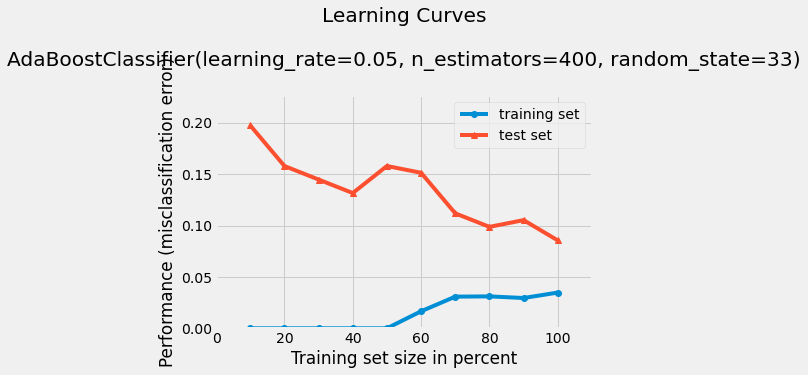

In [490]:
plot_lcurve(best_adb)

Classification report on training data
              precision    recall  f1-score   support

           0     0.9720    0.8910    0.9298       156
           1     0.9631    0.9911    0.9769       448

    accuracy                         0.9652       604
   macro avg     0.9676    0.9410    0.9533       604
weighted avg     0.9654    0.9652    0.9647       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.8108    0.8333    0.8219        36
           1     0.9478    0.9397    0.9437       116

    accuracy                         0.9145       152
   macro avg     0.8793    0.8865    0.8828       152
weighted avg     0.9154    0.9145    0.9149       152



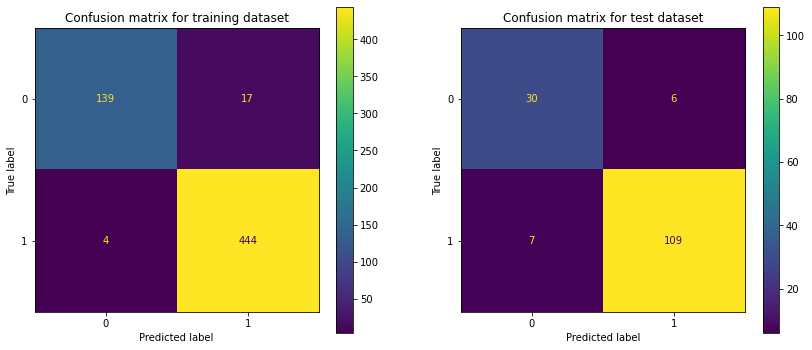

In [491]:
estimator_performance(best_adb)

## 9 XGBoost Classifier
### 9.1 Parameter tuning
Find the optimal parameters of [xgboost.sklearn.XGBModel](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) using [skopt.BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

In [492]:
xgb_search_spaces = {
    'max_depth': Integer(4, 9),
    'min_child_weight': Integer(4, 10),
    'subsample': Real(0.6, 1),
    'colsample_bytree': Real(0.6, 1),
    'learning_rate': Real(0.1, 0.15),
    'n_estimators': [200, 300, 400, 500],
}

pprint(xgb_search_spaces)

{'colsample_bytree': Real(low=0.6, high=1, prior='uniform', transform='identity'),
 'learning_rate': Real(low=0.1, high=0.15, prior='uniform', transform='identity'),
 'max_depth': Integer(low=4, high=9, prior='uniform', transform='identity'),
 'min_child_weight': Integer(low=4, high=10, prior='uniform', transform='identity'),
 'n_estimators': [200, 300, 400, 500],
 'subsample': Real(low=0.6, high=1, prior='uniform', transform='identity')}


In [493]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.1,
                            n_estimators=400,
                            gamma=0,
                            objective='binary:logistic',
                            nthread=-1,
                            scale_pos_weight=3,
                            random_state=RANDOM_SEED)

best_xgb, xgb_cro_val_score, best_xgb_params = search_best(
    X_important_train,
    y_train,
    BayesSearchCV,
    xgb_clf,
    xgb_search_spaces,
    random_state=RANDOM_SEED,
    scoring='f1',
    n_iter=100,
    cv=5,
    n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9368162098547801
Parameter setting that gave the best results:
OrderedDict([('colsample_bytree', 0.6042534622223978),
             ('learning_rate', 0.11893444419668378),
             ('max_depth', 8),
             ('min_child_weight', 4),
             ('n_estimators', 500),
             ('subsample', 0.73308631240614)])


In [494]:
print('Paramater list for the estimator')
pprint(best_xgb.get_params())

Paramater list for the estimator
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6042534622223978,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.11893444419668378,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': -1,
 'nthread': -1,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'random_state': 33,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'subsample': 0.73308631240614,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


### 9.2 Analysis the performance of the best estimator

In [495]:
# Show the prediction on the first sample in test data set
eli5.show_prediction(best_xgb, X_important_test[0], show_feature_values=True, feature_names=IMPORTANT_FEATURES)

In [496]:
print_acc(best_xgb)

Training accuracy: 100.00%
Test accuracy:     95.39%


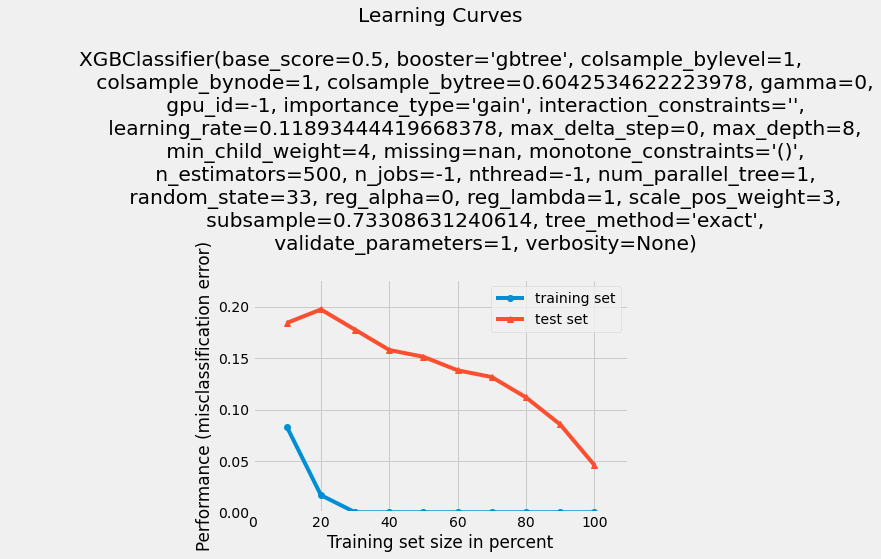

In [497]:
plot_lcurve(best_xgb)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.9394    0.8611    0.8986        36
           1     0.9580    0.9828    0.9702       116

    accuracy                         0.9539       152
   macro avg     0.9487    0.9219    0.9344       152
weighted avg     0.9536    0.9539    0.9532       152



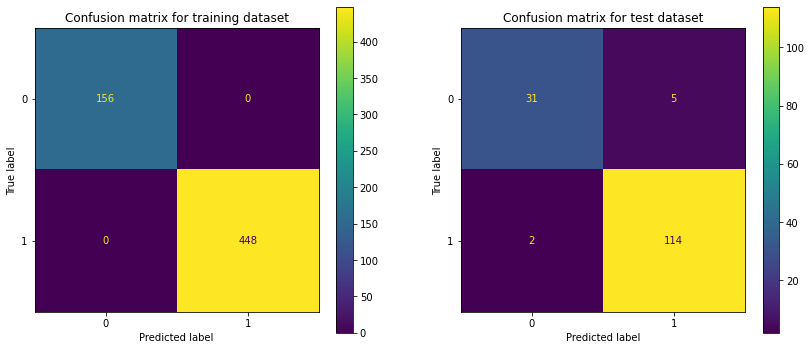

In [498]:
estimator_performance(best_xgb)

## 10 CatBoost Classifier
### 10.1 Parameter tuning
Using [skopt.BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) to optimize the parameter of [CatBoostClassifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html)

In [499]:
ctb_param_grids = {'depth': np.arange(6, 9), 'l2_leaf_reg': [0.8, 1, 2]}

pprint(ctb_param_grids)

{'depth': array([6, 7, 8]), 'l2_leaf_reg': [0.8, 1, 2]}


In [500]:
ctb_model = ctb.CatBoostClassifier(iterations=400,
                                   learning_rate=0.1,
                                   random_seed=RANDOM_SEED)

# grid_search_ctb = ctb_model.grid_search(ctb_param_grids,
#                                            X_important_train,
#                                            y_train,
#                                            cv=5,
#                                            verbose=0,
#                                            partition_random_seed=RANDOM_SEED,
#                                            plot=True)

best_ctb, ctb_cro_val_score, best_ctb_params = search_best(X_important_train,
                                                           y_train,
                                                           GridSearchCV,
                                                           ctb_model,
                                                           ctb_param_grids,
                                                           cv=5,
                                                           n_jobs=-1)

0:	learn: 0.6189387	total: 180ms	remaining: 1m 11s
1:	learn: 0.5589390	total: 221ms	remaining: 43.9s
2:	learn: 0.5121888	total: 262ms	remaining: 34.7s
3:	learn: 0.4654598	total: 304ms	remaining: 30.1s
4:	learn: 0.4225974	total: 346ms	remaining: 27.4s
5:	learn: 0.3931814	total: 389ms	remaining: 25.5s
6:	learn: 0.3629233	total: 435ms	remaining: 24.4s
7:	learn: 0.3394368	total: 483ms	remaining: 23.7s
8:	learn: 0.3143478	total: 524ms	remaining: 22.8s
9:	learn: 0.2963208	total: 565ms	remaining: 22.1s
10:	learn: 0.2778137	total: 608ms	remaining: 21.5s
11:	learn: 0.2621325	total: 655ms	remaining: 21.2s
12:	learn: 0.2476442	total: 698ms	remaining: 20.8s
13:	learn: 0.2355299	total: 741ms	remaining: 20.4s
14:	learn: 0.2269394	total: 781ms	remaining: 20s
15:	learn: 0.2183869	total: 825ms	remaining: 19.8s
16:	learn: 0.2067923	total: 872ms	remaining: 19.6s
17:	learn: 0.1977494	total: 914ms	remaining: 19.4s
18:	learn: 0.1889329	total: 955ms	remaining: 19.2s
19:	learn: 0.1825914	total: 999ms	remainin

161:	learn: 0.0055265	total: 7.28s	remaining: 10.7s
162:	learn: 0.0054520	total: 7.33s	remaining: 10.7s
163:	learn: 0.0053734	total: 7.37s	remaining: 10.6s
164:	learn: 0.0052930	total: 7.41s	remaining: 10.6s
165:	learn: 0.0052398	total: 7.45s	remaining: 10.5s
166:	learn: 0.0051899	total: 7.5s	remaining: 10.5s
167:	learn: 0.0051338	total: 7.54s	remaining: 10.4s
168:	learn: 0.0050602	total: 7.59s	remaining: 10.4s
169:	learn: 0.0050041	total: 7.63s	remaining: 10.3s
170:	learn: 0.0049536	total: 7.67s	remaining: 10.3s
171:	learn: 0.0048824	total: 7.71s	remaining: 10.2s
172:	learn: 0.0048408	total: 7.76s	remaining: 10.2s
173:	learn: 0.0047934	total: 7.8s	remaining: 10.1s
174:	learn: 0.0047392	total: 7.84s	remaining: 10.1s
175:	learn: 0.0046902	total: 7.89s	remaining: 10s
176:	learn: 0.0046435	total: 7.93s	remaining: 9.99s
177:	learn: 0.0046122	total: 7.97s	remaining: 9.95s
178:	learn: 0.0045563	total: 8.02s	remaining: 9.9s
179:	learn: 0.0044920	total: 8.07s	remaining: 9.86s
180:	learn: 0.004

324:	learn: 0.0024363	total: 14.4s	remaining: 3.31s
325:	learn: 0.0024362	total: 14.4s	remaining: 3.27s
326:	learn: 0.0024362	total: 14.5s	remaining: 3.23s
327:	learn: 0.0024362	total: 14.5s	remaining: 3.18s
328:	learn: 0.0024362	total: 14.5s	remaining: 3.14s
329:	learn: 0.0024362	total: 14.6s	remaining: 3.09s
330:	learn: 0.0024359	total: 14.6s	remaining: 3.05s
331:	learn: 0.0024359	total: 14.7s	remaining: 3s
332:	learn: 0.0024359	total: 14.7s	remaining: 2.96s
333:	learn: 0.0024359	total: 14.8s	remaining: 2.92s
334:	learn: 0.0024359	total: 14.8s	remaining: 2.87s
335:	learn: 0.0024359	total: 14.8s	remaining: 2.83s
336:	learn: 0.0024358	total: 14.9s	remaining: 2.78s
337:	learn: 0.0024358	total: 14.9s	remaining: 2.74s
338:	learn: 0.0024358	total: 15s	remaining: 2.69s
339:	learn: 0.0024355	total: 15s	remaining: 2.65s
340:	learn: 0.0024259	total: 15.1s	remaining: 2.6s
341:	learn: 0.0024259	total: 15.1s	remaining: 2.56s
342:	learn: 0.0023999	total: 15.1s	remaining: 2.52s
343:	learn: 0.002399

In [501]:
# print(grid_search_result['params'])

In [502]:
# best_ctb = ctb.CatBoostClassifier(depth=8,
#                                   l2_leaf_reg=1,
#                                   random_seed=RANDOM_SEED).fit(
#                                       X_important_train, y_train, verbose=0)

In [503]:
print('Paramater list for the estimator')
pprint(best_ctb.get_params())

Paramater list for the estimator
{'depth': 7,
 'iterations': 400,
 'l2_leaf_reg': 2,
 'learning_rate': 0.1,
 'random_seed': 33}


### 10.2 Analysis the performance of the best estimator

In [504]:
print_acc(best_ctb)

Training accuracy: 100.00%
Test accuracy:     94.74%


0:	learn: 0.6239759	total: 11.1ms	remaining: 4.45s
1:	learn: 0.5484029	total: 20.9ms	remaining: 4.17s
2:	learn: 0.4971005	total: 31.1ms	remaining: 4.11s
3:	learn: 0.4406013	total: 41ms	remaining: 4.05s
4:	learn: 0.3977008	total: 50.8ms	remaining: 4.01s
5:	learn: 0.3528675	total: 60.3ms	remaining: 3.96s
6:	learn: 0.3184645	total: 70.4ms	remaining: 3.95s
7:	learn: 0.2911697	total: 79.9ms	remaining: 3.92s
8:	learn: 0.2750862	total: 83.9ms	remaining: 3.64s
9:	learn: 0.2555778	total: 95.1ms	remaining: 3.71s
10:	learn: 0.2383660	total: 106ms	remaining: 3.74s
11:	learn: 0.2170578	total: 120ms	remaining: 3.89s
12:	learn: 0.1996565	total: 132ms	remaining: 3.92s
13:	learn: 0.1810683	total: 145ms	remaining: 4.01s
14:	learn: 0.1703487	total: 157ms	remaining: 4.02s
15:	learn: 0.1571456	total: 168ms	remaining: 4.04s
16:	learn: 0.1468446	total: 180ms	remaining: 4.07s
17:	learn: 0.1363049	total: 192ms	remaining: 4.08s
18:	learn: 0.1263179	total: 203ms	remaining: 4.08s
19:	learn: 0.1183710	total: 215ms

161:	learn: 0.0038578	total: 1.83s	remaining: 2.69s
162:	learn: 0.0038428	total: 1.84s	remaining: 2.68s
163:	learn: 0.0038280	total: 1.85s	remaining: 2.67s
164:	learn: 0.0038133	total: 1.86s	remaining: 2.65s
165:	learn: 0.0037947	total: 1.87s	remaining: 2.64s
166:	learn: 0.0037355	total: 1.89s	remaining: 2.63s
167:	learn: 0.0037133	total: 1.9s	remaining: 2.62s
168:	learn: 0.0036995	total: 1.91s	remaining: 2.61s
169:	learn: 0.0036858	total: 1.92s	remaining: 2.59s
170:	learn: 0.0036723	total: 1.93s	remaining: 2.58s
171:	learn: 0.0036551	total: 1.94s	remaining: 2.57s
172:	learn: 0.0036418	total: 1.95s	remaining: 2.56s
173:	learn: 0.0036287	total: 1.96s	remaining: 2.55s
174:	learn: 0.0035742	total: 1.97s	remaining: 2.54s
175:	learn: 0.0035539	total: 1.99s	remaining: 2.53s
176:	learn: 0.0035414	total: 2s	remaining: 2.51s
177:	learn: 0.0035255	total: 2.01s	remaining: 2.5s
178:	learn: 0.0035132	total: 2.02s	remaining: 2.49s
179:	learn: 0.0035011	total: 2.03s	remaining: 2.48s
180:	learn: 0.003

322:	learn: 0.0020805	total: 3.64s	remaining: 868ms
323:	learn: 0.0020804	total: 3.65s	remaining: 857ms
324:	learn: 0.0020804	total: 3.66s	remaining: 846ms
325:	learn: 0.0020804	total: 3.67s	remaining: 834ms
326:	learn: 0.0020804	total: 3.69s	remaining: 823ms
327:	learn: 0.0020804	total: 3.7s	remaining: 812ms
328:	learn: 0.0020803	total: 3.71s	remaining: 801ms
329:	learn: 0.0020803	total: 3.72s	remaining: 790ms
330:	learn: 0.0020803	total: 3.73s	remaining: 779ms
331:	learn: 0.0020802	total: 3.75s	remaining: 767ms
332:	learn: 0.0020802	total: 3.76s	remaining: 756ms
333:	learn: 0.0020802	total: 3.77s	remaining: 745ms
334:	learn: 0.0020796	total: 3.78s	remaining: 734ms
335:	learn: 0.0020650	total: 3.8s	remaining: 723ms
336:	learn: 0.0020528	total: 3.81s	remaining: 712ms
337:	learn: 0.0020457	total: 3.82s	remaining: 701ms
338:	learn: 0.0020318	total: 3.83s	remaining: 689ms
339:	learn: 0.0020317	total: 3.84s	remaining: 678ms
340:	learn: 0.0020315	total: 3.85s	remaining: 667ms
341:	learn: 0.

86:	learn: 0.0092484	total: 1.72s	remaining: 6.19s
87:	learn: 0.0089879	total: 1.74s	remaining: 6.18s
88:	learn: 0.0087839	total: 1.76s	remaining: 6.16s
89:	learn: 0.0086324	total: 1.78s	remaining: 6.14s
90:	learn: 0.0084570	total: 1.8s	remaining: 6.12s
91:	learn: 0.0082917	total: 1.82s	remaining: 6.1s
92:	learn: 0.0080972	total: 1.84s	remaining: 6.08s
93:	learn: 0.0079635	total: 1.86s	remaining: 6.06s
94:	learn: 0.0078331	total: 1.88s	remaining: 6.04s
95:	learn: 0.0077076	total: 1.9s	remaining: 6.02s
96:	learn: 0.0075601	total: 1.92s	remaining: 6.01s
97:	learn: 0.0073557	total: 1.94s	remaining: 5.99s
98:	learn: 0.0071819	total: 1.96s	remaining: 5.97s
99:	learn: 0.0070483	total: 1.98s	remaining: 5.95s
100:	learn: 0.0069754	total: 2s	remaining: 5.93s
101:	learn: 0.0067876	total: 2.02s	remaining: 5.91s
102:	learn: 0.0066754	total: 2.04s	remaining: 5.89s
103:	learn: 0.0065575	total: 2.06s	remaining: 5.87s
104:	learn: 0.0063842	total: 2.08s	remaining: 5.84s
105:	learn: 0.0063013	total: 2.1

246:	learn: 0.0019119	total: 4.93s	remaining: 3.05s
247:	learn: 0.0019119	total: 4.95s	remaining: 3.03s
248:	learn: 0.0019023	total: 4.97s	remaining: 3.01s
249:	learn: 0.0019023	total: 4.99s	remaining: 2.99s
250:	learn: 0.0018932	total: 5.01s	remaining: 2.97s
251:	learn: 0.0018777	total: 5.03s	remaining: 2.95s
252:	learn: 0.0018678	total: 5.05s	remaining: 2.93s
253:	learn: 0.0018587	total: 5.07s	remaining: 2.91s
254:	learn: 0.0018587	total: 5.09s	remaining: 2.89s
255:	learn: 0.0018586	total: 5.11s	remaining: 2.87s
256:	learn: 0.0018509	total: 5.13s	remaining: 2.85s
257:	learn: 0.0018423	total: 5.15s	remaining: 2.83s
258:	learn: 0.0018423	total: 5.17s	remaining: 2.81s
259:	learn: 0.0018373	total: 5.19s	remaining: 2.79s
260:	learn: 0.0018260	total: 5.21s	remaining: 2.77s
261:	learn: 0.0018153	total: 5.23s	remaining: 2.75s
262:	learn: 0.0018152	total: 5.25s	remaining: 2.73s
263:	learn: 0.0018120	total: 5.27s	remaining: 2.71s
264:	learn: 0.0018119	total: 5.29s	remaining: 2.69s
265:	learn: 

8:	learn: 0.2727035	total: 268ms	remaining: 11.7s
9:	learn: 0.2551283	total: 297ms	remaining: 11.6s
10:	learn: 0.2382092	total: 325ms	remaining: 11.5s
11:	learn: 0.2271971	total: 354ms	remaining: 11.4s
12:	learn: 0.2120417	total: 382ms	remaining: 11.4s
13:	learn: 0.1947801	total: 411ms	remaining: 11.3s
14:	learn: 0.1798961	total: 440ms	remaining: 11.3s
15:	learn: 0.1695700	total: 472ms	remaining: 11.3s
16:	learn: 0.1574425	total: 501ms	remaining: 11.3s
17:	learn: 0.1502789	total: 530ms	remaining: 11.2s
18:	learn: 0.1408443	total: 558ms	remaining: 11.2s
19:	learn: 0.1350982	total: 586ms	remaining: 11.1s
20:	learn: 0.1268150	total: 613ms	remaining: 11.1s
21:	learn: 0.1175011	total: 641ms	remaining: 11s
22:	learn: 0.1112957	total: 672ms	remaining: 11s
23:	learn: 0.1045222	total: 700ms	remaining: 11s
24:	learn: 0.0988661	total: 729ms	remaining: 10.9s
25:	learn: 0.0933824	total: 757ms	remaining: 10.9s
26:	learn: 0.0889558	total: 785ms	remaining: 10.8s
27:	learn: 0.0844125	total: 813ms	remai

174:	learn: 0.0031855	total: 5.18s	remaining: 6.65s
175:	learn: 0.0031855	total: 5.21s	remaining: 6.62s
176:	learn: 0.0031624	total: 5.23s	remaining: 6.59s
177:	learn: 0.0031366	total: 5.26s	remaining: 6.56s
178:	learn: 0.0031037	total: 5.29s	remaining: 6.53s
179:	learn: 0.0030716	total: 5.32s	remaining: 6.5s
180:	learn: 0.0030436	total: 5.35s	remaining: 6.48s
181:	learn: 0.0030436	total: 5.38s	remaining: 6.45s
182:	learn: 0.0030097	total: 5.41s	remaining: 6.42s
183:	learn: 0.0029858	total: 5.44s	remaining: 6.39s
184:	learn: 0.0029632	total: 5.47s	remaining: 6.36s
185:	learn: 0.0029372	total: 5.5s	remaining: 6.33s
186:	learn: 0.0029208	total: 5.53s	remaining: 6.3s
187:	learn: 0.0029207	total: 5.56s	remaining: 6.27s
188:	learn: 0.0028959	total: 5.59s	remaining: 6.24s
189:	learn: 0.0028665	total: 5.62s	remaining: 6.21s
190:	learn: 0.0028665	total: 5.65s	remaining: 6.18s
191:	learn: 0.0028377	total: 5.68s	remaining: 6.15s
192:	learn: 0.0028376	total: 5.71s	remaining: 6.12s
193:	learn: 0.0

334:	learn: 0.0017585	total: 9.99s	remaining: 1.94s
335:	learn: 0.0017579	total: 10s	remaining: 1.91s
336:	learn: 0.0017579	total: 10.1s	remaining: 1.88s
337:	learn: 0.0017578	total: 10.1s	remaining: 1.85s
338:	learn: 0.0017556	total: 10.1s	remaining: 1.82s
339:	learn: 0.0017555	total: 10.1s	remaining: 1.79s
340:	learn: 0.0017553	total: 10.2s	remaining: 1.76s
341:	learn: 0.0017552	total: 10.2s	remaining: 1.73s
342:	learn: 0.0017552	total: 10.2s	remaining: 1.7s
343:	learn: 0.0017552	total: 10.3s	remaining: 1.67s
344:	learn: 0.0017552	total: 10.3s	remaining: 1.64s
345:	learn: 0.0017527	total: 10.3s	remaining: 1.61s
346:	learn: 0.0017527	total: 10.3s	remaining: 1.58s
347:	learn: 0.0017483	total: 10.4s	remaining: 1.55s
348:	learn: 0.0017483	total: 10.4s	remaining: 1.52s
349:	learn: 0.0017483	total: 10.4s	remaining: 1.49s
350:	learn: 0.0017483	total: 10.5s	remaining: 1.46s
351:	learn: 0.0017427	total: 10.5s	remaining: 1.43s
352:	learn: 0.0017427	total: 10.5s	remaining: 1.4s
353:	learn: 0.00

96:	learn: 0.0092991	total: 3.83s	remaining: 12s
97:	learn: 0.0090331	total: 3.87s	remaining: 11.9s
98:	learn: 0.0088211	total: 3.9s	remaining: 11.9s
99:	learn: 0.0086098	total: 3.94s	remaining: 11.8s
100:	learn: 0.0084326	total: 3.98s	remaining: 11.8s
101:	learn: 0.0082661	total: 4.03s	remaining: 11.8s
102:	learn: 0.0081256	total: 4.07s	remaining: 11.7s
103:	learn: 0.0079196	total: 4.11s	remaining: 11.7s
104:	learn: 0.0077727	total: 4.14s	remaining: 11.6s
105:	learn: 0.0076074	total: 4.18s	remaining: 11.6s
106:	learn: 0.0074383	total: 4.22s	remaining: 11.6s
107:	learn: 0.0073198	total: 4.26s	remaining: 11.5s
108:	learn: 0.0072139	total: 4.3s	remaining: 11.5s
109:	learn: 0.0070829	total: 4.34s	remaining: 11.4s
110:	learn: 0.0069645	total: 4.38s	remaining: 11.4s
111:	learn: 0.0068399	total: 4.42s	remaining: 11.4s
112:	learn: 0.0066806	total: 4.46s	remaining: 11.3s
113:	learn: 0.0065967	total: 4.5s	remaining: 11.3s
114:	learn: 0.0065016	total: 4.54s	remaining: 11.2s
115:	learn: 0.0063169

255:	learn: 0.0019601	total: 10.1s	remaining: 5.69s
256:	learn: 0.0019480	total: 10.2s	remaining: 5.65s
257:	learn: 0.0019479	total: 10.2s	remaining: 5.61s
258:	learn: 0.0019383	total: 10.2s	remaining: 5.57s
259:	learn: 0.0019269	total: 10.3s	remaining: 5.53s
260:	learn: 0.0019188	total: 10.3s	remaining: 5.49s
261:	learn: 0.0019121	total: 10.4s	remaining: 5.45s
262:	learn: 0.0019083	total: 10.4s	remaining: 5.41s
263:	learn: 0.0018952	total: 10.4s	remaining: 5.37s
264:	learn: 0.0018952	total: 10.5s	remaining: 5.33s
265:	learn: 0.0018784	total: 10.5s	remaining: 5.29s
266:	learn: 0.0018732	total: 10.6s	remaining: 5.25s
267:	learn: 0.0018731	total: 10.6s	remaining: 5.21s
268:	learn: 0.0018731	total: 10.6s	remaining: 5.18s
269:	learn: 0.0018729	total: 10.7s	remaining: 5.13s
270:	learn: 0.0018729	total: 10.7s	remaining: 5.09s
271:	learn: 0.0018568	total: 10.7s	remaining: 5.06s
272:	learn: 0.0018485	total: 10.8s	remaining: 5.02s
273:	learn: 0.0018484	total: 10.8s	remaining: 4.98s
274:	learn: 

15:	learn: 0.1793714	total: 667ms	remaining: 16s
16:	learn: 0.1705376	total: 709ms	remaining: 16s
17:	learn: 0.1599193	total: 751ms	remaining: 15.9s
18:	learn: 0.1508547	total: 791ms	remaining: 15.9s
19:	learn: 0.1452519	total: 832ms	remaining: 15.8s
20:	learn: 0.1392733	total: 875ms	remaining: 15.8s
21:	learn: 0.1313625	total: 919ms	remaining: 15.8s
22:	learn: 0.1262369	total: 961ms	remaining: 15.8s
23:	learn: 0.1184597	total: 1s	remaining: 15.7s
24:	learn: 0.1105529	total: 1.04s	remaining: 15.7s
25:	learn: 0.1033206	total: 1.09s	remaining: 15.6s
26:	learn: 0.0986970	total: 1.13s	remaining: 15.6s
27:	learn: 0.0945108	total: 1.17s	remaining: 15.6s
28:	learn: 0.0894482	total: 1.21s	remaining: 15.5s
29:	learn: 0.0845280	total: 1.25s	remaining: 15.5s
30:	learn: 0.0805972	total: 1.3s	remaining: 15.4s
31:	learn: 0.0767959	total: 1.34s	remaining: 15.4s
32:	learn: 0.0748754	total: 1.38s	remaining: 15.4s
33:	learn: 0.0719619	total: 1.42s	remaining: 15.3s
34:	learn: 0.0703958	total: 1.47s	remai

178:	learn: 0.0031162	total: 7.61s	remaining: 9.39s
179:	learn: 0.0030889	total: 7.65s	remaining: 9.35s
180:	learn: 0.0030664	total: 7.69s	remaining: 9.31s
181:	learn: 0.0030455	total: 7.73s	remaining: 9.26s
182:	learn: 0.0030158	total: 7.78s	remaining: 9.22s
183:	learn: 0.0029871	total: 7.83s	remaining: 9.19s
184:	learn: 0.0029560	total: 7.87s	remaining: 9.14s
185:	learn: 0.0029559	total: 7.91s	remaining: 9.1s
186:	learn: 0.0029315	total: 7.95s	remaining: 9.06s
187:	learn: 0.0029135	total: 7.99s	remaining: 9.01s
188:	learn: 0.0028877	total: 8.04s	remaining: 8.97s
189:	learn: 0.0028628	total: 8.08s	remaining: 8.93s
190:	learn: 0.0028427	total: 8.12s	remaining: 8.89s
191:	learn: 0.0028234	total: 8.19s	remaining: 8.87s
192:	learn: 0.0027874	total: 8.23s	remaining: 8.83s
193:	learn: 0.0027675	total: 8.27s	remaining: 8.78s
194:	learn: 0.0027543	total: 8.31s	remaining: 8.74s
195:	learn: 0.0027542	total: 8.35s	remaining: 8.69s
196:	learn: 0.0027396	total: 8.39s	remaining: 8.65s
197:	learn: 0

337:	learn: 0.0018601	total: 14.4s	remaining: 2.64s
338:	learn: 0.0018540	total: 14.5s	remaining: 2.6s
339:	learn: 0.0018540	total: 14.5s	remaining: 2.56s
340:	learn: 0.0018539	total: 14.5s	remaining: 2.52s
341:	learn: 0.0018539	total: 14.6s	remaining: 2.47s
342:	learn: 0.0018539	total: 14.6s	remaining: 2.43s
343:	learn: 0.0018539	total: 14.7s	remaining: 2.39s
344:	learn: 0.0018539	total: 14.7s	remaining: 2.35s
345:	learn: 0.0018539	total: 14.8s	remaining: 2.3s
346:	learn: 0.0018538	total: 14.8s	remaining: 2.26s
347:	learn: 0.0018538	total: 14.9s	remaining: 2.22s
348:	learn: 0.0018538	total: 14.9s	remaining: 2.18s
349:	learn: 0.0018538	total: 14.9s	remaining: 2.13s
350:	learn: 0.0018538	total: 15s	remaining: 2.09s
351:	learn: 0.0018538	total: 15s	remaining: 2.05s
352:	learn: 0.0018538	total: 15.1s	remaining: 2s
353:	learn: 0.0018537	total: 15.1s	remaining: 1.96s
354:	learn: 0.0018536	total: 15.1s	remaining: 1.92s
355:	learn: 0.0018536	total: 15.2s	remaining: 1.88s
356:	learn: 0.0018534

99:	learn: 0.0129754	total: 4.3s	remaining: 12.9s
100:	learn: 0.0125303	total: 4.35s	remaining: 12.9s
101:	learn: 0.0122004	total: 4.39s	remaining: 12.8s
102:	learn: 0.0118884	total: 4.43s	remaining: 12.8s
103:	learn: 0.0116260	total: 4.48s	remaining: 12.7s
104:	learn: 0.0112963	total: 4.52s	remaining: 12.7s
105:	learn: 0.0109853	total: 4.57s	remaining: 12.7s
106:	learn: 0.0106928	total: 4.61s	remaining: 12.6s
107:	learn: 0.0104420	total: 4.66s	remaining: 12.6s
108:	learn: 0.0101779	total: 4.7s	remaining: 12.5s
109:	learn: 0.0099293	total: 4.74s	remaining: 12.5s
110:	learn: 0.0097730	total: 4.79s	remaining: 12.5s
111:	learn: 0.0096023	total: 4.83s	remaining: 12.4s
112:	learn: 0.0094115	total: 4.87s	remaining: 12.4s
113:	learn: 0.0091871	total: 4.92s	remaining: 12.3s
114:	learn: 0.0090338	total: 4.96s	remaining: 12.3s
115:	learn: 0.0088596	total: 5s	remaining: 12.3s
116:	learn: 0.0086943	total: 5.04s	remaining: 12.2s
117:	learn: 0.0085711	total: 5.09s	remaining: 12.2s
118:	learn: 0.0084

259:	learn: 0.0024091	total: 11.3s	remaining: 6.08s
260:	learn: 0.0024091	total: 11.3s	remaining: 6.04s
261:	learn: 0.0023956	total: 11.4s	remaining: 6s
262:	learn: 0.0023955	total: 11.4s	remaining: 5.96s
263:	learn: 0.0023955	total: 11.5s	remaining: 5.91s
264:	learn: 0.0023934	total: 11.5s	remaining: 5.87s
265:	learn: 0.0023768	total: 11.6s	remaining: 5.83s
266:	learn: 0.0023613	total: 11.6s	remaining: 5.78s
267:	learn: 0.0023425	total: 11.7s	remaining: 5.74s
268:	learn: 0.0023425	total: 11.7s	remaining: 5.7s
269:	learn: 0.0023327	total: 11.7s	remaining: 5.65s
270:	learn: 0.0023327	total: 11.8s	remaining: 5.61s
271:	learn: 0.0023103	total: 11.8s	remaining: 5.57s
272:	learn: 0.0022932	total: 11.9s	remaining: 5.52s
273:	learn: 0.0022932	total: 11.9s	remaining: 5.48s
274:	learn: 0.0022932	total: 12s	remaining: 5.44s
275:	learn: 0.0022932	total: 12s	remaining: 5.39s
276:	learn: 0.0022930	total: 12.1s	remaining: 5.35s
277:	learn: 0.0022930	total: 12.1s	remaining: 5.31s
278:	learn: 0.002293

19:	learn: 0.1722294	total: 897ms	remaining: 17s
20:	learn: 0.1638672	total: 941ms	remaining: 17s
21:	learn: 0.1589087	total: 984ms	remaining: 16.9s
22:	learn: 0.1526150	total: 1.03s	remaining: 16.8s
23:	learn: 0.1434606	total: 1.07s	remaining: 16.7s
24:	learn: 0.1341693	total: 1.11s	remaining: 16.6s
25:	learn: 0.1299187	total: 1.15s	remaining: 16.6s
26:	learn: 0.1255665	total: 1.2s	remaining: 16.5s
27:	learn: 0.1211322	total: 1.24s	remaining: 16.4s
28:	learn: 0.1148814	total: 1.28s	remaining: 16.3s
29:	learn: 0.1099365	total: 1.32s	remaining: 16.3s
30:	learn: 0.1067280	total: 1.36s	remaining: 16.2s
31:	learn: 0.1021893	total: 1.41s	remaining: 16.2s
32:	learn: 0.0992711	total: 1.45s	remaining: 16.1s
33:	learn: 0.0947208	total: 1.49s	remaining: 16.1s
34:	learn: 0.0915178	total: 1.53s	remaining: 16s
35:	learn: 0.0888110	total: 1.58s	remaining: 16s
36:	learn: 0.0842030	total: 1.62s	remaining: 15.9s
37:	learn: 0.0811564	total: 1.67s	remaining: 15.9s
38:	learn: 0.0785885	total: 1.71s	remain

181:	learn: 0.0040439	total: 7.95s	remaining: 9.53s
182:	learn: 0.0040080	total: 8s	remaining: 9.48s
183:	learn: 0.0039687	total: 8.04s	remaining: 9.44s
184:	learn: 0.0039290	total: 8.08s	remaining: 9.39s
185:	learn: 0.0039289	total: 8.13s	remaining: 9.35s
186:	learn: 0.0038913	total: 8.17s	remaining: 9.31s
187:	learn: 0.0038549	total: 8.21s	remaining: 9.26s
188:	learn: 0.0038548	total: 8.26s	remaining: 9.22s
189:	learn: 0.0038029	total: 8.3s	remaining: 9.17s
190:	learn: 0.0038026	total: 8.34s	remaining: 9.13s
191:	learn: 0.0037766	total: 8.39s	remaining: 9.09s
192:	learn: 0.0037296	total: 8.43s	remaining: 9.04s
193:	learn: 0.0037114	total: 8.47s	remaining: 8.99s
194:	learn: 0.0036660	total: 8.51s	remaining: 8.95s
195:	learn: 0.0036359	total: 8.56s	remaining: 8.91s
196:	learn: 0.0036048	total: 8.6s	remaining: 8.87s
197:	learn: 0.0036041	total: 8.65s	remaining: 8.82s
198:	learn: 0.0035683	total: 8.69s	remaining: 8.78s
199:	learn: 0.0035293	total: 8.73s	remaining: 8.73s
200:	learn: 0.003

344:	learn: 0.0022344	total: 15s	remaining: 2.4s
345:	learn: 0.0022343	total: 15.1s	remaining: 2.35s
346:	learn: 0.0022343	total: 15.1s	remaining: 2.31s
347:	learn: 0.0022341	total: 15.2s	remaining: 2.27s
348:	learn: 0.0022341	total: 15.2s	remaining: 2.22s
349:	learn: 0.0022173	total: 15.3s	remaining: 2.18s
350:	learn: 0.0022172	total: 15.3s	remaining: 2.14s
351:	learn: 0.0022172	total: 15.4s	remaining: 2.09s
352:	learn: 0.0022172	total: 15.4s	remaining: 2.05s
353:	learn: 0.0022042	total: 15.4s	remaining: 2.01s
354:	learn: 0.0022041	total: 15.5s	remaining: 1.96s
355:	learn: 0.0022006	total: 15.5s	remaining: 1.92s
356:	learn: 0.0021824	total: 15.6s	remaining: 1.88s
357:	learn: 0.0021824	total: 15.6s	remaining: 1.83s
358:	learn: 0.0021715	total: 15.7s	remaining: 1.79s
359:	learn: 0.0021712	total: 15.7s	remaining: 1.74s
360:	learn: 0.0021712	total: 15.7s	remaining: 1.7s
361:	learn: 0.0021712	total: 15.8s	remaining: 1.66s
362:	learn: 0.0021712	total: 15.8s	remaining: 1.61s
363:	learn: 0.00

105:	learn: 0.0126370	total: 4.66s	remaining: 12.9s
106:	learn: 0.0124137	total: 4.71s	remaining: 12.9s
107:	learn: 0.0121938	total: 4.75s	remaining: 12.8s
108:	learn: 0.0119697	total: 4.8s	remaining: 12.8s
109:	learn: 0.0116618	total: 4.84s	remaining: 12.8s
110:	learn: 0.0114418	total: 4.88s	remaining: 12.7s
111:	learn: 0.0111899	total: 4.93s	remaining: 12.7s
112:	learn: 0.0111748	total: 4.97s	remaining: 12.6s
113:	learn: 0.0109441	total: 5.01s	remaining: 12.6s
114:	learn: 0.0107713	total: 5.06s	remaining: 12.5s
115:	learn: 0.0105554	total: 5.1s	remaining: 12.5s
116:	learn: 0.0103942	total: 5.15s	remaining: 12.4s
117:	learn: 0.0101925	total: 5.19s	remaining: 12.4s
118:	learn: 0.0100042	total: 5.23s	remaining: 12.4s
119:	learn: 0.0097172	total: 5.28s	remaining: 12.3s
120:	learn: 0.0095361	total: 5.33s	remaining: 12.3s
121:	learn: 0.0094273	total: 5.37s	remaining: 12.2s
122:	learn: 0.0092455	total: 5.41s	remaining: 12.2s
123:	learn: 0.0090981	total: 5.46s	remaining: 12.1s
124:	learn: 0.

265:	learn: 0.0025012	total: 11.8s	remaining: 5.93s
266:	learn: 0.0024843	total: 11.8s	remaining: 5.89s
267:	learn: 0.0024674	total: 11.9s	remaining: 5.84s
268:	learn: 0.0024674	total: 11.9s	remaining: 5.8s
269:	learn: 0.0024674	total: 11.9s	remaining: 5.75s
270:	learn: 0.0024469	total: 12s	remaining: 5.71s
271:	learn: 0.0024303	total: 12s	remaining: 5.66s
272:	learn: 0.0024137	total: 12.1s	remaining: 5.62s
273:	learn: 0.0024137	total: 12.1s	remaining: 5.58s
274:	learn: 0.0023991	total: 12.2s	remaining: 5.53s
275:	learn: 0.0023991	total: 12.2s	remaining: 5.49s
276:	learn: 0.0023871	total: 12.3s	remaining: 5.44s
277:	learn: 0.0023675	total: 12.3s	remaining: 5.4s
278:	learn: 0.0023538	total: 12.3s	remaining: 5.35s
279:	learn: 0.0023384	total: 12.4s	remaining: 5.31s
280:	learn: 0.0023384	total: 12.4s	remaining: 5.26s
281:	learn: 0.0023381	total: 12.5s	remaining: 5.22s
282:	learn: 0.0023243	total: 12.5s	remaining: 5.18s
283:	learn: 0.0023055	total: 12.6s	remaining: 5.13s
284:	learn: 0.0023

25:	learn: 0.1331091	total: 1.11s	remaining: 16s
26:	learn: 0.1256474	total: 1.16s	remaining: 16s
27:	learn: 0.1206732	total: 1.21s	remaining: 16s
28:	learn: 0.1152367	total: 1.25s	remaining: 16s
29:	learn: 0.1120710	total: 1.29s	remaining: 16s
30:	learn: 0.1087900	total: 1.34s	remaining: 15.9s
31:	learn: 0.1026892	total: 1.38s	remaining: 15.9s
32:	learn: 0.0993187	total: 1.43s	remaining: 15.9s
33:	learn: 0.0969394	total: 1.47s	remaining: 15.8s
34:	learn: 0.0939606	total: 1.51s	remaining: 15.8s
35:	learn: 0.0914736	total: 1.56s	remaining: 15.7s
36:	learn: 0.0874218	total: 1.6s	remaining: 15.7s
37:	learn: 0.0850055	total: 1.64s	remaining: 15.7s
38:	learn: 0.0820834	total: 1.69s	remaining: 15.6s
39:	learn: 0.0803115	total: 1.73s	remaining: 15.6s
40:	learn: 0.0771888	total: 1.77s	remaining: 15.5s
41:	learn: 0.0738646	total: 1.82s	remaining: 15.5s
42:	learn: 0.0717879	total: 1.86s	remaining: 15.5s
43:	learn: 0.0688532	total: 1.9s	remaining: 15.4s
44:	learn: 0.0670114	total: 1.95s	remaining

187:	learn: 0.0042286	total: 8.25s	remaining: 9.3s
188:	learn: 0.0041920	total: 8.29s	remaining: 9.26s
189:	learn: 0.0041734	total: 8.33s	remaining: 9.21s
190:	learn: 0.0041236	total: 8.38s	remaining: 9.16s
191:	learn: 0.0040915	total: 8.42s	remaining: 9.12s
192:	learn: 0.0040405	total: 8.46s	remaining: 9.08s
193:	learn: 0.0040405	total: 8.51s	remaining: 9.03s
194:	learn: 0.0039898	total: 8.55s	remaining: 8.99s
195:	learn: 0.0039471	total: 8.59s	remaining: 8.94s
196:	learn: 0.0039120	total: 8.64s	remaining: 8.9s
197:	learn: 0.0038791	total: 8.68s	remaining: 8.86s
198:	learn: 0.0038356	total: 8.72s	remaining: 8.81s
199:	learn: 0.0038060	total: 8.77s	remaining: 8.77s
200:	learn: 0.0037804	total: 8.81s	remaining: 8.73s
201:	learn: 0.0037362	total: 8.86s	remaining: 8.69s
202:	learn: 0.0037018	total: 8.9s	remaining: 8.64s
203:	learn: 0.0036751	total: 8.95s	remaining: 8.6s
204:	learn: 0.0036297	total: 8.99s	remaining: 8.55s
205:	learn: 0.0036126	total: 9.04s	remaining: 8.51s
206:	learn: 0.00

350:	learn: 0.0021702	total: 15.4s	remaining: 2.15s
351:	learn: 0.0021702	total: 15.4s	remaining: 2.1s
352:	learn: 0.0021702	total: 15.5s	remaining: 2.06s
353:	learn: 0.0021701	total: 15.5s	remaining: 2.02s
354:	learn: 0.0021701	total: 15.6s	remaining: 1.97s
355:	learn: 0.0021701	total: 15.6s	remaining: 1.93s
356:	learn: 0.0021700	total: 15.7s	remaining: 1.89s
357:	learn: 0.0021700	total: 15.7s	remaining: 1.84s
358:	learn: 0.0021700	total: 15.7s	remaining: 1.8s
359:	learn: 0.0021700	total: 15.8s	remaining: 1.75s
360:	learn: 0.0021689	total: 15.8s	remaining: 1.71s
361:	learn: 0.0021689	total: 15.9s	remaining: 1.67s
362:	learn: 0.0021688	total: 15.9s	remaining: 1.62s
363:	learn: 0.0021688	total: 16s	remaining: 1.58s
364:	learn: 0.0021688	total: 16s	remaining: 1.53s
365:	learn: 0.0021688	total: 16.1s	remaining: 1.49s
366:	learn: 0.0021686	total: 16.1s	remaining: 1.45s
367:	learn: 0.0021626	total: 16.1s	remaining: 1.4s
368:	learn: 0.0021626	total: 16.2s	remaining: 1.36s
369:	learn: 0.00216

115:	learn: 0.0114346	total: 5.08s	remaining: 12.4s
116:	learn: 0.0112868	total: 5.12s	remaining: 12.4s
117:	learn: 0.0110962	total: 5.17s	remaining: 12.3s
118:	learn: 0.0109513	total: 5.21s	remaining: 12.3s
119:	learn: 0.0106960	total: 5.25s	remaining: 12.3s
120:	learn: 0.0105124	total: 5.3s	remaining: 12.2s
121:	learn: 0.0102909	total: 5.34s	remaining: 12.2s
122:	learn: 0.0100816	total: 5.38s	remaining: 12.1s
123:	learn: 0.0099429	total: 5.43s	remaining: 12.1s
124:	learn: 0.0097511	total: 5.47s	remaining: 12s
125:	learn: 0.0095721	total: 5.52s	remaining: 12s
126:	learn: 0.0094005	total: 5.56s	remaining: 12s
127:	learn: 0.0092347	total: 5.61s	remaining: 11.9s
128:	learn: 0.0090855	total: 5.65s	remaining: 11.9s
129:	learn: 0.0088976	total: 5.69s	remaining: 11.8s
130:	learn: 0.0086838	total: 5.74s	remaining: 11.8s
131:	learn: 0.0085615	total: 5.78s	remaining: 11.7s
132:	learn: 0.0084135	total: 5.83s	remaining: 11.7s
133:	learn: 0.0082473	total: 5.87s	remaining: 11.7s
134:	learn: 0.00809

276:	learn: 0.0026183	total: 12.2s	remaining: 5.41s
277:	learn: 0.0026003	total: 12.2s	remaining: 5.37s
278:	learn: 0.0026003	total: 12.3s	remaining: 5.32s
279:	learn: 0.0026003	total: 12.3s	remaining: 5.28s
280:	learn: 0.0026002	total: 12.4s	remaining: 5.23s
281:	learn: 0.0025998	total: 12.4s	remaining: 5.19s
282:	learn: 0.0025998	total: 12.4s	remaining: 5.14s
283:	learn: 0.0025998	total: 12.5s	remaining: 5.1s
284:	learn: 0.0025998	total: 12.5s	remaining: 5.06s
285:	learn: 0.0025998	total: 12.6s	remaining: 5.02s
286:	learn: 0.0025998	total: 12.6s	remaining: 4.97s
287:	learn: 0.0025800	total: 12.7s	remaining: 4.93s
288:	learn: 0.0025654	total: 12.7s	remaining: 4.88s
289:	learn: 0.0025654	total: 12.8s	remaining: 4.84s
290:	learn: 0.0025654	total: 12.8s	remaining: 4.79s
291:	learn: 0.0025653	total: 12.8s	remaining: 4.75s
292:	learn: 0.0025653	total: 12.9s	remaining: 4.71s
293:	learn: 0.0025653	total: 12.9s	remaining: 4.66s
294:	learn: 0.0025653	total: 13s	remaining: 4.62s
295:	learn: 0.0

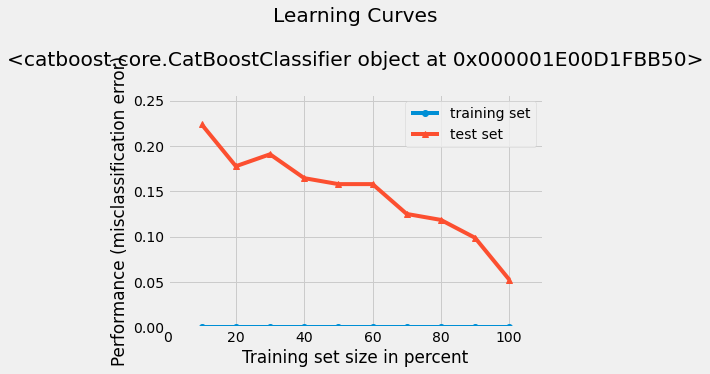

In [505]:
plot_lcurve(best_ctb)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.9375    0.8333    0.8824        36
           1     0.9500    0.9828    0.9661       116

    accuracy                         0.9474       152
   macro avg     0.9437    0.9080    0.9242       152
weighted avg     0.9470    0.9474    0.9463       152



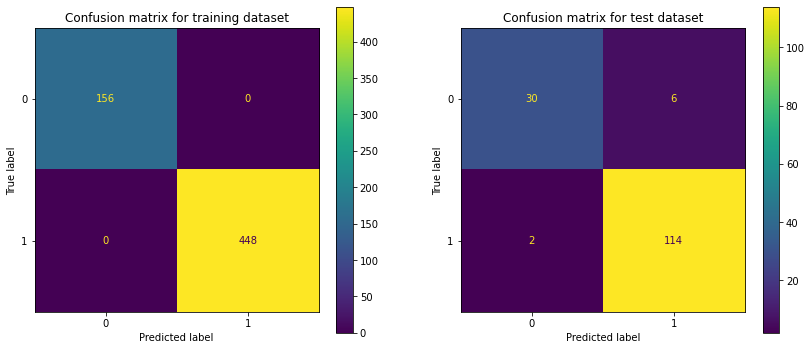

In [506]:
estimator_performance(best_ctb)

## 11 LGBM Classifier
### 11.1 Parameter tuning
Find the optimal parameters of [lightgbm.LGBMClassifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#) using [skopt.BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)

In [507]:
lgbm_search_spaces = {
    'num_leaves': Integer(10, 40),
    'max_depth': Integer(4, 10),
    'colsample_bytree': Real(0.8, 1),
    'subsample': Real(0.8, 1)
}
 
pprint(lgbm_search_spaces)

{'colsample_bytree': Real(low=0.8, high=1, prior='uniform', transform='identity'),
 'max_depth': Integer(low=4, high=10, prior='uniform', transform='identity'),
 'num_leaves': Integer(low=10, high=40, prior='uniform', transform='identity'),
 'subsample': Real(low=0.8, high=1, prior='uniform', transform='identity')}


In [508]:
lgbm_model = lgb.LGBMClassifier(objective='binary',
                                subsample_for_bin=200,
                                subsample=0.8,
                                subsample_freq=1,
                                min_split_gain=0.5,
                                min_child_weight=1,
                                min_child_samples=5,
                                scale_pos_weight=1,
                                n_jobs=-1,
                                random_state=RANDOM_SEED,
                                silent=True,
                                verbose=-1)

bs_lgbm, lgbm_cro_val_score, bs_lgbm_params = search_best(
    X_important_train,
    y_train,
    BayesSearchCV,
    lgbm_model,
    lgbm_search_spaces,
    n_iter=100,
    cv=5,
    scoring='f1',
    random_state=RANDOM_SEED,
    n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9428445654513201
Parameter setting that gave the best results:
OrderedDict([('colsample_bytree', 0.8393621213386645),
             ('max_depth', 7),
             ('num_leaves', 10),
             ('subsample', 0.9244816072246916)])


In [509]:
best_lgbm, lgbm_cro_val_score, best_lgbm_params = search_best(
    X_important_train,
    y_train,
    BayesSearchCV,
    lgbm_model, {
        'learning_rate': Real(0.05, 0.15),
        'n_estimators': np.arange(200, 600, 100)
    },
    n_iter=100,
    cv=5,
    scoring='f1',
    random_state=RANDOM_SEED,
    n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9379098130976485
Parameter setting that gave the best results:
OrderedDict([('learning_rate', 0.10112909303205934), ('n_estimators', 500)])


In [510]:
print('Paramater list for the estimator')
pprint(best_lgbm.get_params())

Paramater list for the estimator
{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.10112909303205934,
 'max_depth': -1,
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 33,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'scale_pos_weight': 1,
 'silent': True,
 'subsample': 0.8,
 'subsample_for_bin': 200,
 'subsample_freq': 1,
 'verbose': -1}


### 11.2 Assess the performance of the best estimator

In [511]:
# Show the prediction on the first sample in test data set
eli5.show_prediction(best_lgbm, X_important_test[0], show_feature_values=True, feature_names=IMPORTANT_FEATURES)

In [512]:
print_acc(best_lgbm)

Training accuracy: 100.00%
Test accuracy:     94.74%


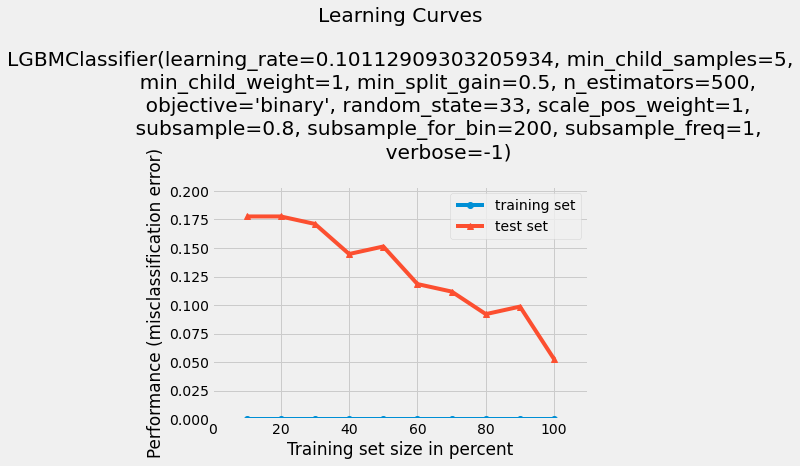

In [513]:
plot_lcurve(best_lgbm)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.9118    0.8611    0.8857        36
           1     0.9576    0.9741    0.9658       116

    accuracy                         0.9474       152
   macro avg     0.9347    0.9176    0.9258       152
weighted avg     0.9468    0.9474    0.9468       152



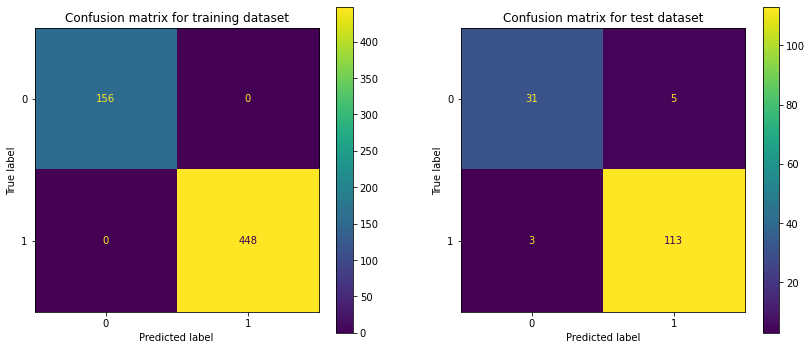

In [514]:
estimator_performance(best_lgbm)

## 12 MLP Classifier
Find the optimal parameters of [sklearn.neural_network.MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html?highlight=mlpclassifier#sklearn.neural_network.MLPClassifier) using [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)

In [515]:
mlp_param_grids = {
    'batch_size': [10, 15, 20, 30],
    'activation': ['relu', 'logistic', 'relu']
}

pprint(mlp_param_grids)

{'activation': ['relu', 'logistic', 'relu'], 'batch_size': [10, 15, 20, 30]}


In [516]:
mlp_model = MLPClassifier(hidden_layer_sizes=(X_important_train.shape[1], 100,
                                              50, 10, 2),
                          max_iter=1000,
                          activation='relu',
                          solver='sgd',
                          batch_size=10,
                          learning_rate_init=0.01,
                          momentum=0.9,
                          random_state=RANDOM_SEED)

best_mlp, mlp_cro_val_score, best_mlp_params = search_best(X_important_train,
                                                           y_train,
                                                           GridSearchCV,
                                                           mlp_model,
                                                           mlp_param_grids,
                                                           scoring='f1',
                                                           cv=5,
                                                           n_jobs=-1)

Mean cross-validated score of the best_estimator: 0.9181837502453039
Parameter setting that gave the best results:
{'activation': 'relu', 'batch_size': 10}


In [517]:
print('Paramater list for the estimator')
pprint(best_mlp.get_params())

Paramater list for the estimator
{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 10,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (221, 100, 50, 10, 2),
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 33,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}


### 12.2 Assess the performance of the best estimator

In [518]:
print_acc(best_mlp)

Training accuracy: 100.00%
Test accuracy:     94.08%


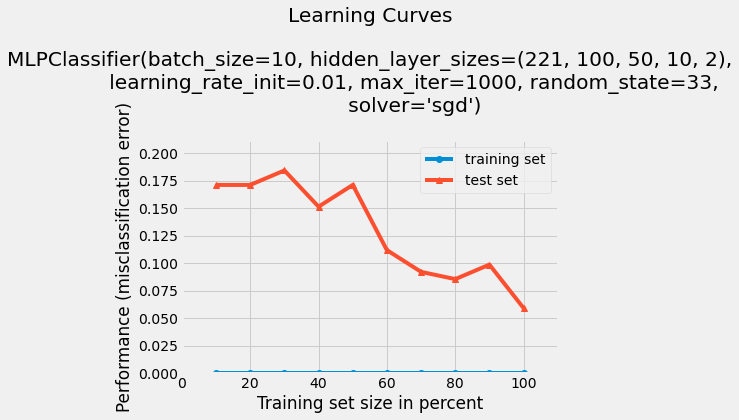

In [519]:
plot_lcurve(best_mlp)

Classification report on training data
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       156
           1     1.0000    1.0000    1.0000       448

    accuracy                         1.0000       604
   macro avg     1.0000    1.0000    1.0000       604
weighted avg     1.0000    1.0000    1.0000       604

Classification report on test data
              precision    recall  f1-score   support

           0     0.9355    0.8056    0.8657        36
           1     0.9421    0.9828    0.9620       116

    accuracy                         0.9408       152
   macro avg     0.9388    0.8942    0.9138       152
weighted avg     0.9406    0.9408    0.9392       152



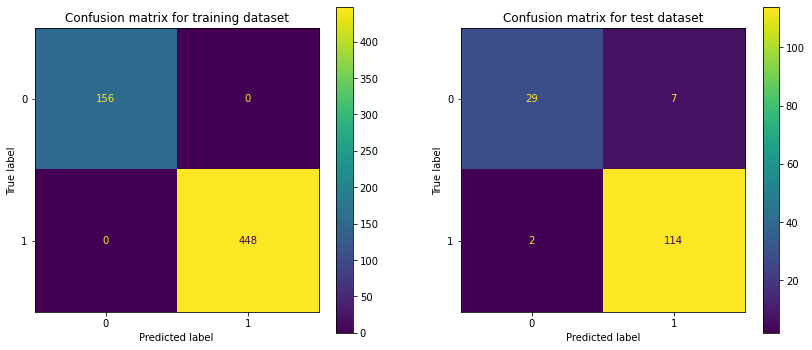

In [520]:
estimator_performance(best_mlp)

## 13 Summary

In [553]:
estimators = [
     nb, best_lr, best_svm, best_knn, best_xtrees,best_adb, best_xgb, best_ctb, best_lgbm, best_mlp
]

estimator_names = [
    'GuassianNB','Logistic Regression','SVM','KNN', 'Extra Trees', 'AdaBoost' ,'XGBoost Classifier',
    'CatBoost Classifier', 'LightGBM Classifier', 'MLP Classifier'
]

In [554]:
def plot_bar_acc(acc, est_names, title):
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x=est_names, y=acc)
    plt.ylim((0, 1.3))
    ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
    totals = []
    for i in ax.patches:
        totals.append(i.get_height())

    # set individual bar lables using above list
    total = sum(totals)

    # set individual bar lables using above list
    for i, n in zip(ax.patches, range(len(acc))):
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0.1,
                i.get_height() + .05,
                '{:.2f}%'.format(acc[n]*100),
                fontsize=15,
                color='black')
    plt.xlabel('estimators')
    plt.ylabel('accuracy')
    plt.title(title)
    plt.show()

def print_all_acc(train_acc, test_acc):
    for trn_acc,tst_acc, name in zip(train_acc, test_acc, estimator_names):
        print(name + ' training accuracy: {:.2f}'.format(trn_acc*100))
        print(name + ' test accuracy: {:.2f}\n'.format(tst_acc*100))

In [555]:
train_acc = [
    estimator.score(X_important_train, y_train) for estimator in estimators
]
test_acc = [
    estimator.score(X_important_test, y_test) for estimator in estimators
]
cro_val_scores = [
    lr_cro_val_score, svm_cro_val_score, knn_cro_val_score,adb_cro_val_score,
    xtrees_cro_val_score, xgb_cro_val_score, ctb_cro_val_score,
    lgbm_cro_val_score, mlp_cro_val_score
]

In [556]:
print_all_acc(train_acc, test_acc)

GuassianNB training accuracy: 82.62
GuassianNB test accuracy: 80.92

Logistic Regression training accuracy: 88.25
Logistic Regression test accuracy: 86.18

SVM training accuracy: 100.00
SVM test accuracy: 90.13

KNN training accuracy: 100.00
KNN test accuracy: 92.76

Extra Trees training accuracy: 100.00
Extra Trees test accuracy: 93.42

AdaBoost training accuracy: 96.52
AdaBoost test accuracy: 91.45

XGBoost Classifier training accuracy: 100.00
XGBoost Classifier test accuracy: 95.39

CatBoost Classifier training accuracy: 100.00
CatBoost Classifier test accuracy: 94.74

LightGBM Classifier training accuracy: 100.00
LightGBM Classifier test accuracy: 94.74

MLP Classifier training accuracy: 100.00
MLP Classifier test accuracy: 94.08



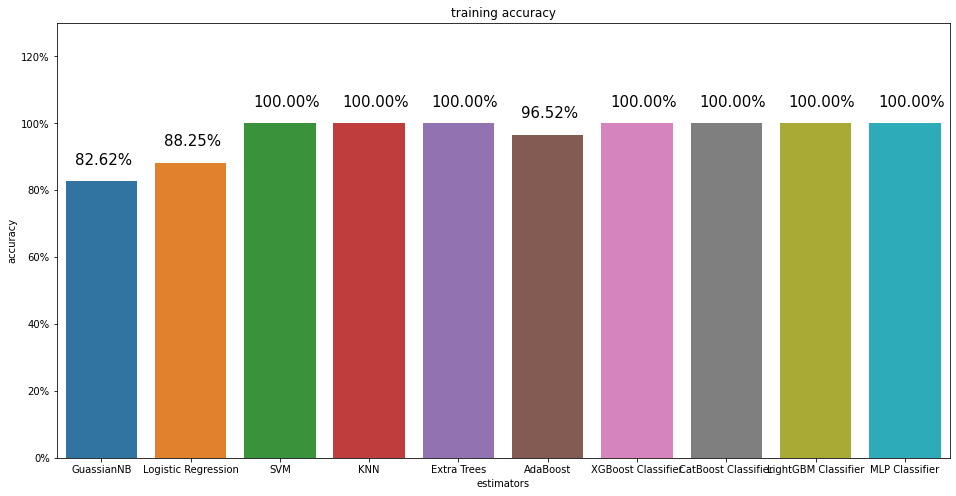

In [557]:
plot_bar_acc(train_acc, estimator_names, 'training accuracy')

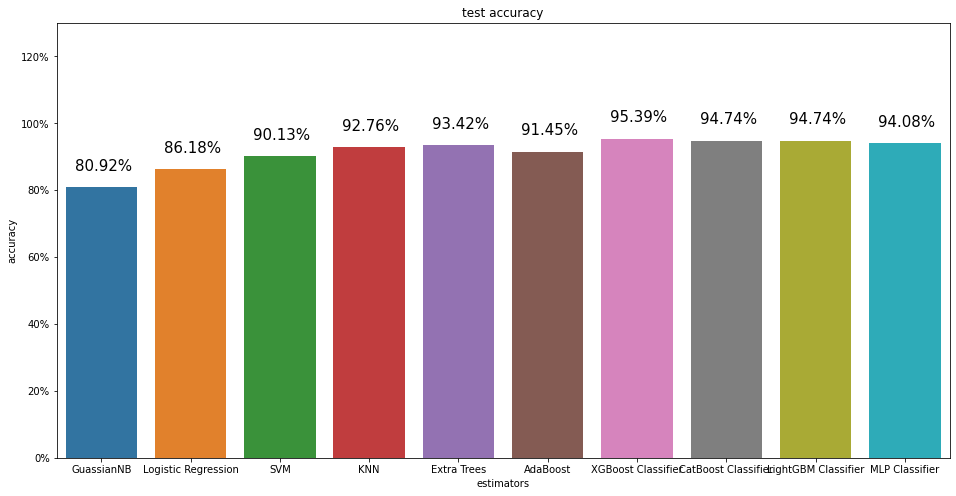

In [558]:
plot_bar_acc(test_acc,est_names, 'test accuracy')

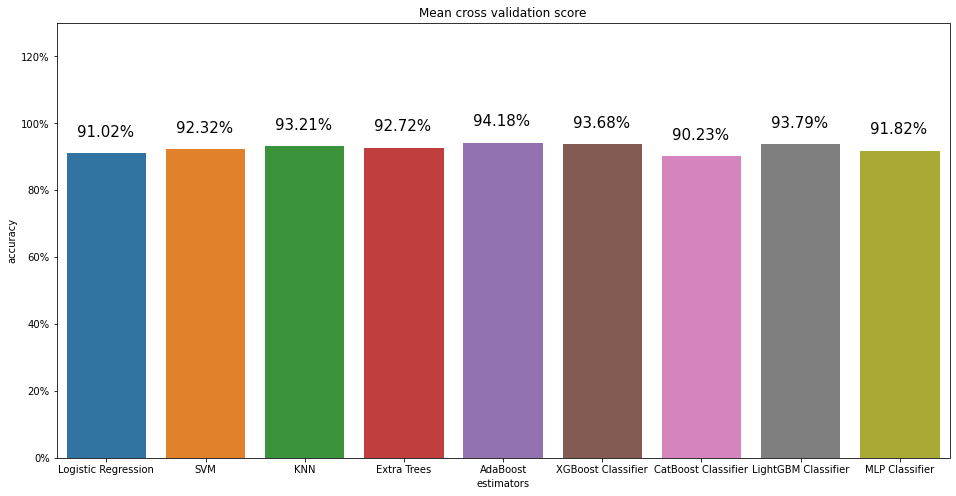

In [559]:
plot_bar_acc(cro_val_scores, estimator_names[1:], 'Mean cross validation score')

In [212]:
eli5.show_weights(best_xtrees, feature_names = IMPORTANT_FEATURES)

Weight,Feature
0.0420 ± 0.0927,mean_MFCC_2nd_coef
0.0289 ± 0.0597,std_delta_log_energy
0.0277 ± 0.0539,tqwt_entropy_log_dec_27
0.0214 ± 0.0688,std_9th_delta_delta
0.0201 ± 0.0663,tqwt_stdValue_dec_11
0.0173 ± 0.0570,std_7th_delta_delta
0.0170 ± 0.0427,std_4th_delta_delta
0.0165 ± 0.0662,tqwt_minValue_dec_13
0.0161 ± 0.0318,tqwt_TKEO_std_dec_19
0.0156 ± 0.0476,std_9th_delta


In [213]:
eli5.show_weights(best_xgb, feature_names = IMPORTANT_FEATURES)

Weight,Feature
0.0367,tqwt_stdValue_dec_11
0.0284,tqwt_TKEO_mean_dec_12
0.0246,det_LT_TKEO_mean_9_coef
0.0240,std_10th_delta_delta
0.0229,mean_MFCC_2nd_coef
0.0200,tqwt_entropy_shannon_dec_35
0.0174,tqwt_entropy_shannon_dec_36
0.0153,tqwt_stdValue_dec_15
0.0143,tqwt_entropy_shannon_dec_19
0.0140,tqwt_skewnessValue_dec_21


In [214]:
eli5.show_weights(best_ctb, feature_names = IMPORTANT_FEATURES)

Weight,Feature
0.0516,std_delta_log_energy
0.0265,tqwt_entropy_log_dec_27
0.0211,tqwt_entropy_log_dec_1
0.0204,std_7th_delta
0.0189,tqwt_energy_dec_21
0.0189,std_9th_delta
0.0164,mean_MFCC_6th_coef
0.0160,mean_MFCC_2nd_coef
0.0159,tqwt_TKEO_std_dec_19
0.0140,std_7th_delta_delta


In [215]:
eli5.show_weights(best_lgbm, feature_names = IMPORTANT_FEATURES)

Weight,Feature
0.0816,mean_MFCC_2nd_coef
0.0761,std_delta_log_energy
0.0535,tqwt_TKEO_mean_dec_12
0.0347,tqwt_entropy_log_dec_27
0.0282,mean_MFCC_6th_coef
0.0265,tqwt_entropy_log_dec_35
0.0265,tqwt_entropy_log_dec_33
0.0248,std_7th_delta
0.0219,std_4th_delta_delta
0.0179,tqwt_entropy_log_dec_1


In [532]:
print('The best classifier is XGBoostClassifier with parameters')
pprint(best_xgb.get_params())

The best classifier is XGBoostClassifier with parameters
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6042534622223978,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.11893444419668378,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 4,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 500,
 'n_jobs': -1,
 'nthread': -1,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'random_state': 33,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 3,
 'subsample': 0.73308631240614,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}


In [632]:
# function return the first 100 importance features as a set
def important_features(feature_importances):
    important_indices = np.argsort(feature_importances*-1)[:100]
    return set(FEATURES[important_indices])

In [633]:
# Get the first 100 important features for each best estimator which
# is able to produce feature weights
lr_imp = important_features(best_lr.coef_[0])
xtrees_imp = important_features(best_xtrees.feature_importances_)
adb_imp = important_features(best_adb.feature_importances_) 
xgb_imp = important_features(best_xgb.feature_importances_)
ctb_imp = important_features(best_ctb.feature_importances_)
lgbm_imp = important_features(best_lgbm.feature_importances_)

In [634]:
common_features = lr_imp & xtrees_imp & adb_imp & adb_imp & xgb_imp & ctb_imp & lgbm_imp

In [635]:
print("People with high index in the features below tend to suffer from Pakinson's disease:")
pprint(common_features)

People with high index in the features below tend to suffer from Pakinson's disease:
{'Ed_3_coef',
 'Ed_7_coef',
 'app_det_TKEO_mean_2_coef',
 'app_det_TKEO_mean_4_coef',
 'app_entropy_log_7_coef',
 'app_entropy_log_8_coef',
 'app_entropy_shannon_9_coef',
 'det_TKEO_mean_10_coef',
 'det_TKEO_mean_6_coef',
 'det_TKEO_std_1_coef',
 'det_entropy_log_8_coef',
 'f3',
 'f4',
 'locAbsJitter',
 'meanIntensity',
 'meanNoiseToHarmHarmonicity',
 'std_0th_delta',
 'std_11th_delta',
 'std_1st_delta',
 'std_3rd_delta',
 'std_7th_delta'}
